# Build models

In [1]:
import pkg_resources
from subprocess import call

packages = [dist.project_name for dist in pkg_resources.working_set]
call("pip3 install " + "-i https://pypi.tuna.tsinghua.edu.cn/simple" + " --upgrade " + ' '.join(packages), shell=True)

2

In [2]:
from torch import nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__() 
        self.conv1 = nn.Conv2d(1, 32, 7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x1 = F.max_pool2d(self.relu1(self.conv1(x)),2)
        x2 = F.max_pool2d(self.relu2(self.conv2(x1)),2)
        x3 = self.dropout1(x2)
        x4 = torch.flatten(x3,1)
        x5 = F.relu(self.fc1(x4))
        x6 = self.sigmoid(self.fc2(x5))
        return x6
        
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 7*7*256, bias=False)
        self.bn1 = nn.BatchNorm1d(7*7*256)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.ConvTranspose2d(256,128,(4, 4), stride=(1, 1), padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.ConvTranspose2d(128,64,(4, 4), stride=(2, 2), padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.ConvTranspose2d(64,32,(4, 4), stride=(1, 1), padding=0, bias=False)
        self.bn4 = nn.BatchNorm2d(32)
        self.tanh = nn.Tanh()
        self.conv5 = nn.ConvTranspose2d(32,1,(4, 4), stride=(1, 1), padding=0, bias=False)
        
    def forward(self, x):
        x1 = self.relu1(self.bn1(self.fc1(x)))
        x2 = x1.view(-1,256,7,7)
        x3 = self.relu2(self.bn2(self.conv2(x2)))
        x4 = self.relu3(self.bn3(self.conv3(x3)))
        x5 = self.relu3(self.bn4(self.conv4(x4)))
        x6 = self.tanh(self.conv5(x5))
        x6.permute(0,2,3,1)
        return x6


# Define options

In [3]:
import argparse

class args:
    epochs = 15
    num_users = 20
    frac=0.5
    local_ep=10               
    local_bs= 64         
    lr=0.0005         
    momentum=0.5

    # model arguments
    model = 'GAN'
    kernel_num=9                
    kernel_sizes='3,4,5'
    num_channels=1
    norm='batch_norm'
    num_filters=32
    max_pool = 'True'

    # other arguments
    dataset='mnist'
    num_classes=10
    gpu=True
    optimizer = 'adam'
    iid=1
    unequal=0
    stopping_rounds=10
    verbose=1
    seed=1


# Sampling

In [4]:
import numpy as np
from torchvision import datasets, transforms

def mnist_iid(dataset, num_users):
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users


def mnist_noniid(dataset, num_users):

    num_shards, num_imgs = 200, 300
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.targets.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users


def mnist_noniid_unequal(dataset, num_users):

    # 60,000 training imgs --> 50 imgs/shard X 1200 shards
    num_shards, num_imgs = 1200, 50
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.targets.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # Minimum and maximum shards assigned per client:
    min_shard = 1
    max_shard = 30

    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_users)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)

    # Assign the shards randomly to each client
    if sum(random_shard_size) > num_shards:

        for i in range(num_users):

            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_users):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    else:
        for i in range(num_users):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[k] = np.concatenate(
                    (dict_users[k], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

    return dict_users

# Update

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

class DatasetSplit(Dataset):

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

class LocalUpdate(object):
    def __init__(self, args, dataset, idxs, logger):
        self.args = args
        self.logger = logger
        self.trainloader, self.validloader, self.testloader = self.train_val_test(dataset, list(idxs))
        self.device = 'cuda' if args.gpu else 'cpu'
        self.criterion = nn.BCELoss()

    def train_val_test(self, dataset, idxs):
        """
        Returns train, validation and test dataloaders for a given dataset
        and user indexes.
        """
        # split indexes for train, validation, and test (80, 10, 10)
        idxs_train = idxs[:int(0.8*len(idxs))]
        idxs_val = idxs[int(0.8*len(idxs)):int(0.9*len(idxs))]
        idxs_test = idxs[int(0.9*len(idxs)):]

        trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
                                 batch_size=self.args.local_bs, shuffle=True)
        validloader = DataLoader(DatasetSplit(dataset, idxs_val),
                                 batch_size=int(len(idxs_val)/10), shuffle=False)
        testloader = DataLoader(DatasetSplit(dataset, idxs_test),
                                batch_size=int(len(idxs_test)/10), shuffle=False)
        return trainloader, validloader, testloader

    def update_weights(self, model_gen, model_dis, global_round):
        # Set mode to train model
        model_gen.train()
        model_dis.train()
        epoch_loss_dis = []
        epoch_loss_gen = []

        # Set optimizer for the local updates
        if self.args.optimizer == 'sgd':
            g_optimizer = torch.optim.SGD(model_gen.parameters(), lr=self.args.lr,
                                        momentum=0.5)
            d_optimizer = torch.optim.SGD(model_dis.parameters(), lr=self.args.lr,
                                        momentum=0.5)
        elif self.args.optimizer == 'adam':
            g_optimizer = torch.optim.Adam(model_gen.parameters(), lr=self.args.lr,
                                         weight_decay=1e-4)
            d_optimizer = torch.optim.Adam(model_dis.parameters(), lr=self.args.lr,
                                         weight_decay=1e-4)

        for iter in range(self.args.local_ep):
            d_batch_loss = []
            g_batch_loss = []
            for batch_idx, (images, _) in enumerate(self.trainloader):
                images = images.to(self.device)
                # print("image shape: ", images.shape)
#                 print("label shape: ", labels.shape)
                g_optimizer.zero_grad()
                d_optimizer.zero_grad()
                
                real_labels = torch.ones(images.shape[0], 1).to(self.device)
                fake_labels = torch.zeros(images.shape[0], 1).to(self.device)

                # real labels
                outputs = model_dis(images)
                # print("outputs shape: ", outputs.shape)
                d_loss_real = self.criterion(outputs, real_labels)

                # fake labels
                z = torch.randn(images.shape[0], 100).to(self.device)
                outputs = model_dis(model_gen(z))
                d_loss_fake = self.criterion(outputs, fake_labels)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                d_optimizer.step()

                #training Generator
                z = torch.randn(images.shape[0], 100).to(self.device)
                fake_images = model_gen(z)
                outputs = model_dis(fake_images)
                g_loss = self.criterion(outputs, real_labels)

                #update Generator
                g_loss.backward()
                g_optimizer.step()
                
                d_batch_loss.append(d_loss.item())
                g_batch_loss.append(g_loss.item())
                
            print('| Global Round : {} | Local Epoch : {} | Generator Loss: {:.6f} | Discriminator Loss: {:.6f}'.format(
                         global_round, iter, np.mean(g_batch_loss), np.mean(d_batch_loss)))

        return model_gen.state_dict(), model_dis.state_dict(), np.mean(g_batch_loss),  np.mean(d_batch_loss)

    def inference(self, model):
        """ Returns the inference accuracy and loss.
        """
        model.eval()
        loss, total, correct = 0.0, 0.0, 0.0

        for batch_idx, (images, labels) in enumerate(self.testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            # Inference
            outputs = model(images)
            batch_loss = self.criterion(outputs, labels)
            loss += batch_loss.item()
            # Prediction
            _, pred_labels = torch.max(outputs, 1)
            pred_labels = pred_labels.view(-1)
            correct += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)

        accuracy = correct/total
        return accuracy, loss

def test_inference(args, model, test_dataset):
    """ Returns the test accuracy and loss.
    """
    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    device = 'cuda' if args.gpu else 'cpu'
    criterion = nn.NLLLoss().to(device)
    testloader = DataLoader(test_dataset, batch_size=128,
                            shuffle=False)

    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct/total
    return accuracy, loss

# utils

In [6]:
import copy
import torch
from torchvision import datasets, transforms

def get_dataset(args):
    """ Returns train and test datasets and a user group which is a dict where
    the keys are the user index and the values are the corresponding data for
    each of those users.
    """
    data_dir = '../data/mnist/'

    apply_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

    train_dataset = datasets.MNIST(data_dir, train=True, download=True,
                                   transform=apply_transform)

    test_dataset = datasets.MNIST(data_dir, train=False, download=True,
                                  transform=apply_transform)

    if args.iid:
        # Sample IID user data from Mnist
        user_groups = mnist_iid(train_dataset, args.num_users)
    else:
        # Sample Non-IID user data from Mnist
        if args.unequal:
            # Chose uneuqal splits for every user
            user_groups = mnist_noniid_unequal(train_dataset, args.num_users)
        else:
            # Chose euqal splits for every user
            user_groups = mnist_noniid(train_dataset, args.num_users)

    return train_dataset, test_dataset, user_groups


def average_weights(w):
    """
    Returns the average of the weights.
    """
    w_avg = w[0]
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg


def exp_details(args):
    print('\nExperimental details:')
    print(f'    Model     : {args.model}')
    print(f'    Optimizer : {args.optimizer}')
    print(f'    Learning  : {args.lr}')
    print(f'    Global Rounds   : {args.epochs}\n')

    print('    Federated parameters:')
    if args.iid:
        print('    IID')
    else:
        print('    Non-IID')
    print(f'    Fraction of users  : {args.frac}')
    print(f'    Local Batch size   : {args.local_bs}')
    print(f'    Local Epochs       : {args.local_ep}\n')


# Federated

In [7]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter
from torchvision.utils import save_image

start_time = time.time()

# define paths
path_project = os.path.abspath('.')
logger = SummaryWriter('./logs')

exp_details(args)

# if args.gpu_id:
#     torch.cuda.set_device(args.gpu_id)
device = 'cuda' if args.gpu else 'cpu'

# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)

# BUILD MODEL
gen = Generator().to(device)
dis = Discriminator().to(device)

print('Generator model:\n')
print(gen)
print('Discriminator model:\n')
print(dis)

# copy weights
#global_weights = global_model.state_dict()
global_gen_w = gen.state_dict()
global_dis_w = dis.state_dict()

# Training
train_loss_gen, train_loss_dis = [], []
print_every = 2
val_loss_pre, counter = 0, 0

for epoch in tqdm(range(args.epochs)):
    d_local_w, d_local_loss = [], []
    g_local_w, g_local_loss = [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')

    gen.train()
    dis.train()
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)

    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=train_dataset, idxs=user_groups[idx], logger=logger)
        g_w, d_w, g_loss, d_loss = local.update_weights(
            model_gen=gen, model_dis=dis, global_round=epoch)

    g_local_w.append(g_w)
    d_local_w.append(d_w)
    g_local_loss.append(g_loss)
    d_local_loss.append(d_loss)

    # update global weights
    g_global_w = average_weights(g_local_w)
    d_global_w = average_weights(d_local_w)

    # update global weights
    gen.load_state_dict(g_global_w)
    dis.load_state_dict(d_global_w)

    gen_loss_avg = sum(g_local_loss) / len(g_local_loss)
    dis_loss_avg = sum(d_local_loss) / len(d_local_loss)
    train_loss_gen.append(gen_loss_avg)
    train_loss_dis.append(dis_loss_avg)
    
    z = torch.randn(args.local_bs, 100).to('cuda')
    fake_images = gen(z)
    save_image(fake_images, os.path.join("gan_images-{}.png".format(epoch+1)))

    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f'Training Loss for GENERATOR : {np.mean(train_loss_gen)}')
        print(f'Training Loss DISCRIMITOR: {np.mean(train_loss_dis)}')



Experimental details:
    Model     : GAN
    Optimizer : adam
    Learning  : 0.0005
    Global Rounds   : 15

    Federated parameters:
    IID
    Fraction of users  : 0.5
    Local Batch size   : 64
    Local Epochs       : 10



  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Generator model:

Generator(
  (fc1): Linear(in_features=100, out_features=12544, bias=False)
  (bn1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (conv5): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Discriminator model:

Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 64, kern

<ipython-input-5-5c022ab7106a>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


| Global Round : 0 | Local Epoch : 0 | Generator Loss: 2.117674 | Discriminator Loss: 0.637192
| Global Round : 0 | Local Epoch : 1 | Generator Loss: 4.221185 | Discriminator Loss: 0.174473
| Global Round : 0 | Local Epoch : 2 | Generator Loss: 4.649474 | Discriminator Loss: 0.130670
| Global Round : 0 | Local Epoch : 3 | Generator Loss: 4.852785 | Discriminator Loss: 0.055637
| Global Round : 0 | Local Epoch : 4 | Generator Loss: 4.727764 | Discriminator Loss: 0.048201
| Global Round : 0 | Local Epoch : 5 | Generator Loss: 5.517199 | Discriminator Loss: 0.037391
| Global Round : 0 | Local Epoch : 6 | Generator Loss: 5.765597 | Discriminator Loss: 0.024295
| Global Round : 0 | Local Epoch : 7 | Generator Loss: 5.749978 | Discriminator Loss: 0.026103
| Global Round : 0 | Local Epoch : 8 | Generator Loss: 6.386971 | Discriminator Loss: 0.008440
| Global Round : 0 | Local Epoch : 9 | Generator Loss: 7.156588 | Discriminator Loss: 0.008463
| Global Round : 0 | Local Epoch : 0 | Generator L

| Global Round : 0 | Local Epoch : 6 | Generator Loss: 10.883392 | Discriminator Loss: 0.000145
| Global Round : 0 | Local Epoch : 7 | Generator Loss: 10.561577 | Discriminator Loss: 0.000879
| Global Round : 0 | Local Epoch : 8 | Generator Loss: 12.002574 | Discriminator Loss: 0.000061
| Global Round : 0 | Local Epoch : 9 | Generator Loss: 10.425510 | Discriminator Loss: 0.000089
| Global Round : 0 | Local Epoch : 0 | Generator Loss: 9.532824 | Discriminator Loss: 0.007822
| Global Round : 0 | Local Epoch : 1 | Generator Loss: 10.905065 | Discriminator Loss: 0.000175
| Global Round : 0 | Local Epoch : 2 | Generator Loss: 12.209861 | Discriminator Loss: 0.001734
| Global Round : 0 | Local Epoch : 3 | Generator Loss: 10.997702 | Discriminator Loss: 0.004568
| Global Round : 0 | Local Epoch : 4 | Generator Loss: 11.347908 | Discriminator Loss: 0.001482
| Global Round : 0 | Local Epoch : 5 | Generator Loss: 9.642943 | Discriminator Loss: 0.000254
| Global Round : 0 | Local Epoch : 6 | Gen

  7%|█████▍                                                                            | 1/15 [01:48<25:12, 108.03s/it]

| Global Round : 0 | Local Epoch : 9 | Generator Loss: 11.676358 | Discriminator Loss: 0.000156

 | Global Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | Generator Loss: 12.701557 | Discriminator Loss: 0.003114
| Global Round : 1 | Local Epoch : 1 | Generator Loss: 10.669847 | Discriminator Loss: 0.000420
| Global Round : 1 | Local Epoch : 2 | Generator Loss: 9.965330 | Discriminator Loss: 0.004480
| Global Round : 1 | Local Epoch : 3 | Generator Loss: 11.405822 | Discriminator Loss: 0.000327
| Global Round : 1 | Local Epoch : 4 | Generator Loss: 11.684965 | Discriminator Loss: 0.002068
| Global Round : 1 | Local Epoch : 5 | Generator Loss: 9.302288 | Discriminator Loss: 0.001144
| Global Round : 1 | Local Epoch : 6 | Generator Loss: 11.705260 | Discriminator Loss: 0.000166
| Global Round : 1 | Local Epoch : 7 | Generator Loss: 11.436945 | Discriminator Loss: 0.000497
| Global Round : 1 | Local Epoch : 8 | Generator Loss: 10.450750 | Discriminator Loss: 0.000118
| Global 

| Global Round : 1 | Local Epoch : 5 | Generator Loss: 9.889541 | Discriminator Loss: 0.000214
| Global Round : 1 | Local Epoch : 6 | Generator Loss: 10.694590 | Discriminator Loss: 0.000172
| Global Round : 1 | Local Epoch : 7 | Generator Loss: 11.661404 | Discriminator Loss: 0.000102
| Global Round : 1 | Local Epoch : 8 | Generator Loss: 12.321530 | Discriminator Loss: 0.000132
| Global Round : 1 | Local Epoch : 9 | Generator Loss: 13.282390 | Discriminator Loss: 0.000065
| Global Round : 1 | Local Epoch : 0 | Generator Loss: 12.533349 | Discriminator Loss: 0.000461
| Global Round : 1 | Local Epoch : 1 | Generator Loss: 12.353278 | Discriminator Loss: 0.000258
| Global Round : 1 | Local Epoch : 2 | Generator Loss: 11.186405 | Discriminator Loss: 0.005173
| Global Round : 1 | Local Epoch : 3 | Generator Loss: 10.372028 | Discriminator Loss: 0.000487
| Global Round : 1 | Local Epoch : 4 | Generator Loss: 11.467396 | Discriminator Loss: 0.000051
| Global Round : 1 | Local Epoch : 5 | Ge

 13%|██████████▉                                                                       | 2/15 [07:37<54:12, 250.19s/it]

| Global Round : 1 | Local Epoch : 9 | Generator Loss: 12.176586 | Discriminator Loss: 0.007729
 
Avg Training Stats after 2 global rounds:
Training Loss for GENERATOR : 11.9264720552846
Training Loss DISCRIMITOR: 0.003942356019021382

 | Global Training Round : 3 |

| Global Round : 2 | Local Epoch : 0 | Generator Loss: 12.585686 | Discriminator Loss: 0.000243
| Global Round : 2 | Local Epoch : 1 | Generator Loss: 12.532135 | Discriminator Loss: 0.000645
| Global Round : 2 | Local Epoch : 2 | Generator Loss: 12.106043 | Discriminator Loss: 0.001542
| Global Round : 2 | Local Epoch : 3 | Generator Loss: 11.316376 | Discriminator Loss: 0.000245
| Global Round : 2 | Local Epoch : 4 | Generator Loss: 12.072529 | Discriminator Loss: 0.000071
| Global Round : 2 | Local Epoch : 5 | Generator Loss: 12.387070 | Discriminator Loss: 0.002170
| Global Round : 2 | Local Epoch : 6 | Generator Loss: 10.081626 | Discriminator Loss: 0.003561
| Global Round : 2 | Local Epoch : 7 | Generator Loss: 9.825

| Global Round : 2 | Local Epoch : 3 | Generator Loss: 11.003269 | Discriminator Loss: 0.000787
| Global Round : 2 | Local Epoch : 4 | Generator Loss: 11.519426 | Discriminator Loss: 0.000052
| Global Round : 2 | Local Epoch : 5 | Generator Loss: 11.703420 | Discriminator Loss: 0.000079
| Global Round : 2 | Local Epoch : 6 | Generator Loss: 12.196838 | Discriminator Loss: 0.000034
| Global Round : 2 | Local Epoch : 7 | Generator Loss: 12.072956 | Discriminator Loss: 0.001543
| Global Round : 2 | Local Epoch : 8 | Generator Loss: 11.299772 | Discriminator Loss: 0.014594
| Global Round : 2 | Local Epoch : 9 | Generator Loss: 8.935561 | Discriminator Loss: 0.002081
| Global Round : 2 | Local Epoch : 0 | Generator Loss: 12.596828 | Discriminator Loss: 0.000388
| Global Round : 2 | Local Epoch : 1 | Generator Loss: 12.384461 | Discriminator Loss: 0.000096
| Global Round : 2 | Local Epoch : 2 | Generator Loss: 11.670733 | Discriminator Loss: 0.000081
| Global Round : 2 | Local Epoch : 3 | Ge

 20%|████████████████▍                                                                 | 3/15 [12:37<54:35, 272.99s/it]

| Global Round : 2 | Local Epoch : 9 | Generator Loss: 10.023118 | Discriminator Loss: 0.002346

 | Global Training Round : 4 |

| Global Round : 3 | Local Epoch : 0 | Generator Loss: 12.546277 | Discriminator Loss: 0.001646
| Global Round : 3 | Local Epoch : 1 | Generator Loss: 11.169639 | Discriminator Loss: 0.000378
| Global Round : 3 | Local Epoch : 2 | Generator Loss: 10.891200 | Discriminator Loss: 0.000689
| Global Round : 3 | Local Epoch : 3 | Generator Loss: 12.668822 | Discriminator Loss: 0.000020
| Global Round : 3 | Local Epoch : 4 | Generator Loss: 11.586562 | Discriminator Loss: 0.000094
| Global Round : 3 | Local Epoch : 5 | Generator Loss: 12.176825 | Discriminator Loss: 0.000029
| Global Round : 3 | Local Epoch : 6 | Generator Loss: 12.234218 | Discriminator Loss: 0.000025
| Global Round : 3 | Local Epoch : 7 | Generator Loss: 11.894060 | Discriminator Loss: 0.000148
| Global Round : 3 | Local Epoch : 8 | Generator Loss: 11.731086 | Discriminator Loss: 0.000044
| Globa

| Global Round : 3 | Local Epoch : 5 | Generator Loss: 12.189010 | Discriminator Loss: 0.000037
| Global Round : 3 | Local Epoch : 6 | Generator Loss: 11.968451 | Discriminator Loss: 0.000041
| Global Round : 3 | Local Epoch : 7 | Generator Loss: 12.190195 | Discriminator Loss: 0.000039
| Global Round : 3 | Local Epoch : 8 | Generator Loss: 12.244420 | Discriminator Loss: 0.000029
| Global Round : 3 | Local Epoch : 9 | Generator Loss: 12.404875 | Discriminator Loss: 0.000032
| Global Round : 3 | Local Epoch : 0 | Generator Loss: 11.521657 | Discriminator Loss: 0.001841
| Global Round : 3 | Local Epoch : 1 | Generator Loss: 10.161811 | Discriminator Loss: 0.000446
| Global Round : 3 | Local Epoch : 2 | Generator Loss: 11.025211 | Discriminator Loss: 0.002541
| Global Round : 3 | Local Epoch : 3 | Generator Loss: 10.327179 | Discriminator Loss: 0.000152
| Global Round : 3 | Local Epoch : 4 | Generator Loss: 11.742260 | Discriminator Loss: 0.000049
| Global Round : 3 | Local Epoch : 5 | G

 27%|█████████████████████▊                                                            | 4/15 [15:44<43:48, 238.96s/it]

| Global Round : 3 | Local Epoch : 9 | Generator Loss: 13.588301 | Discriminator Loss: 0.000012
 
Avg Training Stats after 4 global rounds:
Training Loss for GENERATOR : 11.866090799632826
Training Loss DISCRIMITOR: 0.0025604453509366094

 | Global Training Round : 5 |

| Global Round : 4 | Local Epoch : 0 | Generator Loss: 12.035886 | Discriminator Loss: 0.000689
| Global Round : 4 | Local Epoch : 1 | Generator Loss: 11.648794 | Discriminator Loss: 0.008863
| Global Round : 4 | Local Epoch : 2 | Generator Loss: 12.467392 | Discriminator Loss: 0.000175
| Global Round : 4 | Local Epoch : 3 | Generator Loss: 11.549525 | Discriminator Loss: 0.000204
| Global Round : 4 | Local Epoch : 4 | Generator Loss: 10.240602 | Discriminator Loss: 0.000694
| Global Round : 4 | Local Epoch : 5 | Generator Loss: 10.488362 | Discriminator Loss: 0.000132
| Global Round : 4 | Local Epoch : 6 | Generator Loss: 11.422250 | Discriminator Loss: 0.000061
| Global Round : 4 | Local Epoch : 7 | Generator Loss: 11

| Global Round : 4 | Local Epoch : 3 | Generator Loss: 13.983712 | Discriminator Loss: 0.000212
| Global Round : 4 | Local Epoch : 4 | Generator Loss: 14.466768 | Discriminator Loss: 0.000007
| Global Round : 4 | Local Epoch : 5 | Generator Loss: 13.430765 | Discriminator Loss: 0.000042
| Global Round : 4 | Local Epoch : 6 | Generator Loss: 13.060114 | Discriminator Loss: 0.000018
| Global Round : 4 | Local Epoch : 7 | Generator Loss: 13.282847 | Discriminator Loss: 0.000021
| Global Round : 4 | Local Epoch : 8 | Generator Loss: 13.091642 | Discriminator Loss: 0.000022
| Global Round : 4 | Local Epoch : 9 | Generator Loss: 12.819268 | Discriminator Loss: 0.000019
| Global Round : 4 | Local Epoch : 0 | Generator Loss: 12.299611 | Discriminator Loss: 0.000267
| Global Round : 4 | Local Epoch : 1 | Generator Loss: 12.799281 | Discriminator Loss: 0.000122
| Global Round : 4 | Local Epoch : 2 | Generator Loss: 13.023324 | Discriminator Loss: 0.000041
| Global Round : 4 | Local Epoch : 3 | G

 33%|███████████████████████████▎                                                      | 5/15 [18:53<36:50, 221.03s/it]

| Global Round : 4 | Local Epoch : 9 | Generator Loss: 15.047825 | Discriminator Loss: 0.000022

 | Global Training Round : 6 |

| Global Round : 5 | Local Epoch : 0 | Generator Loss: 12.323232 | Discriminator Loss: 0.000140
| Global Round : 5 | Local Epoch : 1 | Generator Loss: 11.740985 | Discriminator Loss: 0.002418
| Global Round : 5 | Local Epoch : 2 | Generator Loss: 10.586851 | Discriminator Loss: 0.000607
| Global Round : 5 | Local Epoch : 3 | Generator Loss: 10.630819 | Discriminator Loss: 0.002282
| Global Round : 5 | Local Epoch : 4 | Generator Loss: 11.733196 | Discriminator Loss: 0.000057
| Global Round : 5 | Local Epoch : 5 | Generator Loss: 11.922893 | Discriminator Loss: 0.000051
| Global Round : 5 | Local Epoch : 6 | Generator Loss: 11.915645 | Discriminator Loss: 0.000218
| Global Round : 5 | Local Epoch : 7 | Generator Loss: 12.425926 | Discriminator Loss: 0.000045
| Global Round : 5 | Local Epoch : 8 | Generator Loss: 12.708882 | Discriminator Loss: 0.000016
| Globa

| Global Round : 5 | Local Epoch : 4 | Generator Loss: 12.231812 | Discriminator Loss: 0.000031
| Global Round : 5 | Local Epoch : 5 | Generator Loss: 12.365685 | Discriminator Loss: 0.000092
| Global Round : 5 | Local Epoch : 6 | Generator Loss: 11.993314 | Discriminator Loss: 0.002298
| Global Round : 5 | Local Epoch : 7 | Generator Loss: 12.975007 | Discriminator Loss: 0.006936
| Global Round : 5 | Local Epoch : 8 | Generator Loss: 9.162545 | Discriminator Loss: 0.001141
| Global Round : 5 | Local Epoch : 9 | Generator Loss: 11.399068 | Discriminator Loss: 0.000162
| Global Round : 5 | Local Epoch : 0 | Generator Loss: 13.767145 | Discriminator Loss: 0.000121
| Global Round : 5 | Local Epoch : 1 | Generator Loss: 12.044953 | Discriminator Loss: 0.000054
| Global Round : 5 | Local Epoch : 2 | Generator Loss: 12.579851 | Discriminator Loss: 0.000068
| Global Round : 5 | Local Epoch : 3 | Generator Loss: 13.137264 | Discriminator Loss: 0.000013
| Global Round : 5 | Local Epoch : 4 | Ge

 40%|████████████████████████████████▊                                                 | 6/15 [20:28<26:41, 177.94s/it]

| Global Round : 5 | Local Epoch : 9 | Generator Loss: 13.436302 | Discriminator Loss: 0.000097
 
Avg Training Stats after 6 global rounds:
Training Loss for GENERATOR : 12.658081564986915
Training Loss DISCRIMITOR: 0.001726739644851705

 | Global Training Round : 7 |

| Global Round : 6 | Local Epoch : 0 | Generator Loss: 12.603684 | Discriminator Loss: 0.000100
| Global Round : 6 | Local Epoch : 1 | Generator Loss: 13.121794 | Discriminator Loss: 0.000094
| Global Round : 6 | Local Epoch : 2 | Generator Loss: 11.740377 | Discriminator Loss: 0.003111
| Global Round : 6 | Local Epoch : 3 | Generator Loss: 13.071082 | Discriminator Loss: 0.001473
| Global Round : 6 | Local Epoch : 4 | Generator Loss: 13.592060 | Discriminator Loss: 0.000159
| Global Round : 6 | Local Epoch : 5 | Generator Loss: 13.997405 | Discriminator Loss: 0.000007
| Global Round : 6 | Local Epoch : 6 | Generator Loss: 13.403347 | Discriminator Loss: 0.000015
| Global Round : 6 | Local Epoch : 7 | Generator Loss: 12.

| Global Round : 6 | Local Epoch : 3 | Generator Loss: 12.449195 | Discriminator Loss: 0.000034
| Global Round : 6 | Local Epoch : 4 | Generator Loss: 12.636739 | Discriminator Loss: 0.000016
| Global Round : 6 | Local Epoch : 5 | Generator Loss: 12.294672 | Discriminator Loss: 0.000022
| Global Round : 6 | Local Epoch : 6 | Generator Loss: 12.103582 | Discriminator Loss: 0.000038
| Global Round : 6 | Local Epoch : 7 | Generator Loss: 12.387625 | Discriminator Loss: 0.000481
| Global Round : 6 | Local Epoch : 8 | Generator Loss: 12.425983 | Discriminator Loss: 0.000024
| Global Round : 6 | Local Epoch : 9 | Generator Loss: 12.512902 | Discriminator Loss: 0.000012
| Global Round : 6 | Local Epoch : 0 | Generator Loss: 12.408804 | Discriminator Loss: 0.000051
| Global Round : 6 | Local Epoch : 1 | Generator Loss: 11.986390 | Discriminator Loss: 0.000064
| Global Round : 6 | Local Epoch : 2 | Generator Loss: 13.506505 | Discriminator Loss: 0.000042
| Global Round : 6 | Local Epoch : 3 | G

 47%|██████████████████████████████████████▎                                           | 7/15 [22:12<20:31, 153.91s/it]

| Global Round : 6 | Local Epoch : 9 | Generator Loss: 11.698714 | Discriminator Loss: 0.003842

 | Global Training Round : 8 |

| Global Round : 7 | Local Epoch : 0 | Generator Loss: 22.949091 | Discriminator Loss: 0.071810
| Global Round : 7 | Local Epoch : 1 | Generator Loss: 12.030457 | Discriminator Loss: 0.000051
| Global Round : 7 | Local Epoch : 2 | Generator Loss: 9.885744 | Discriminator Loss: 0.000266
| Global Round : 7 | Local Epoch : 3 | Generator Loss: 11.259729 | Discriminator Loss: 0.000213
| Global Round : 7 | Local Epoch : 4 | Generator Loss: 11.974894 | Discriminator Loss: 0.001477
| Global Round : 7 | Local Epoch : 5 | Generator Loss: 14.371645 | Discriminator Loss: 0.000355
| Global Round : 7 | Local Epoch : 6 | Generator Loss: 11.914831 | Discriminator Loss: 0.000024
| Global Round : 7 | Local Epoch : 7 | Generator Loss: 11.902422 | Discriminator Loss: 0.000026
| Global Round : 7 | Local Epoch : 8 | Generator Loss: 11.868879 | Discriminator Loss: 0.000023
| Global

| Global Round : 7 | Local Epoch : 5 | Generator Loss: 13.459529 | Discriminator Loss: 0.000042
| Global Round : 7 | Local Epoch : 6 | Generator Loss: 11.852403 | Discriminator Loss: 0.000318
| Global Round : 7 | Local Epoch : 7 | Generator Loss: 12.548813 | Discriminator Loss: 0.000018
| Global Round : 7 | Local Epoch : 8 | Generator Loss: 12.658414 | Discriminator Loss: 0.000018
| Global Round : 7 | Local Epoch : 9 | Generator Loss: 13.117500 | Discriminator Loss: 0.000010
| Global Round : 7 | Local Epoch : 0 | Generator Loss: 12.876965 | Discriminator Loss: 0.000027
| Global Round : 7 | Local Epoch : 1 | Generator Loss: 12.928616 | Discriminator Loss: 0.000112
| Global Round : 7 | Local Epoch : 2 | Generator Loss: 11.938729 | Discriminator Loss: 0.000106
| Global Round : 7 | Local Epoch : 3 | Generator Loss: 13.451045 | Discriminator Loss: 0.000021
| Global Round : 7 | Local Epoch : 4 | Generator Loss: 13.026335 | Discriminator Loss: 0.000016
| Global Round : 7 | Local Epoch : 5 | G

 53%|███████████████████████████████████████████▋                                      | 8/15 [24:28<17:17, 148.28s/it]

| Global Round : 7 | Local Epoch : 9 | Generator Loss: 13.406621 | Discriminator Loss: 0.014314
 
Avg Training Stats after 8 global rounds:
Training Loss for GENERATOR : 12.631728112697601
Training Loss DISCRIMITOR: 0.003564455933662421

 | Global Training Round : 9 |

| Global Round : 8 | Local Epoch : 0 | Generator Loss: 13.235415 | Discriminator Loss: 0.000070
| Global Round : 8 | Local Epoch : 1 | Generator Loss: 13.076962 | Discriminator Loss: 0.000871
| Global Round : 8 | Local Epoch : 2 | Generator Loss: 10.830005 | Discriminator Loss: 0.000132
| Global Round : 8 | Local Epoch : 3 | Generator Loss: 11.981526 | Discriminator Loss: 0.000037
| Global Round : 8 | Local Epoch : 4 | Generator Loss: 12.529422 | Discriminator Loss: 0.000018
| Global Round : 8 | Local Epoch : 5 | Generator Loss: 12.510031 | Discriminator Loss: 0.000040
| Global Round : 8 | Local Epoch : 6 | Generator Loss: 11.944469 | Discriminator Loss: 0.000036
| Global Round : 8 | Local Epoch : 7 | Generator Loss: 12.

| Global Round : 8 | Local Epoch : 3 | Generator Loss: 12.151248 | Discriminator Loss: 0.000562
| Global Round : 8 | Local Epoch : 4 | Generator Loss: 11.758720 | Discriminator Loss: 0.000054
| Global Round : 8 | Local Epoch : 5 | Generator Loss: 13.527168 | Discriminator Loss: 0.000007
| Global Round : 8 | Local Epoch : 6 | Generator Loss: 12.008007 | Discriminator Loss: 0.000052
| Global Round : 8 | Local Epoch : 7 | Generator Loss: 12.811374 | Discriminator Loss: 0.000011
| Global Round : 8 | Local Epoch : 8 | Generator Loss: 13.181282 | Discriminator Loss: 0.000009
| Global Round : 8 | Local Epoch : 9 | Generator Loss: 12.877429 | Discriminator Loss: 0.000016
| Global Round : 8 | Local Epoch : 0 | Generator Loss: 11.393743 | Discriminator Loss: 0.000139
| Global Round : 8 | Local Epoch : 1 | Generator Loss: 13.078059 | Discriminator Loss: 0.000017
| Global Round : 8 | Local Epoch : 2 | Generator Loss: 11.098825 | Discriminator Loss: 0.000457
| Global Round : 8 | Local Epoch : 3 | G

 60%|█████████████████████████████████████████████████▏                                | 9/15 [26:20<13:40, 136.74s/it]

| Global Round : 8 | Local Epoch : 9 | Generator Loss: 15.216545 | Discriminator Loss: 0.000007

 | Global Training Round : 10 |

| Global Round : 9 | Local Epoch : 0 | Generator Loss: 13.254275 | Discriminator Loss: 0.000034
| Global Round : 9 | Local Epoch : 1 | Generator Loss: 11.836072 | Discriminator Loss: 0.000272
| Global Round : 9 | Local Epoch : 2 | Generator Loss: 11.822021 | Discriminator Loss: 0.000039
| Global Round : 9 | Local Epoch : 3 | Generator Loss: 11.566879 | Discriminator Loss: 0.000053
| Global Round : 9 | Local Epoch : 4 | Generator Loss: 13.992620 | Discriminator Loss: 0.000014
| Global Round : 9 | Local Epoch : 5 | Generator Loss: 12.781238 | Discriminator Loss: 0.000144
| Global Round : 9 | Local Epoch : 6 | Generator Loss: 12.077961 | Discriminator Loss: 0.000034
| Global Round : 9 | Local Epoch : 7 | Generator Loss: 13.800388 | Discriminator Loss: 0.000032
| Global Round : 9 | Local Epoch : 8 | Generator Loss: 13.210140 | Discriminator Loss: 0.000010
| Glob

| Global Round : 9 | Local Epoch : 4 | Generator Loss: 12.644015 | Discriminator Loss: 0.000031
| Global Round : 9 | Local Epoch : 5 | Generator Loss: 13.038398 | Discriminator Loss: 0.000012
| Global Round : 9 | Local Epoch : 6 | Generator Loss: 11.581823 | Discriminator Loss: 0.000312
| Global Round : 9 | Local Epoch : 7 | Generator Loss: 12.402578 | Discriminator Loss: 0.000025
| Global Round : 9 | Local Epoch : 8 | Generator Loss: 11.732319 | Discriminator Loss: 0.000055
| Global Round : 9 | Local Epoch : 9 | Generator Loss: 12.668945 | Discriminator Loss: 0.000051
| Global Round : 9 | Local Epoch : 0 | Generator Loss: 12.086644 | Discriminator Loss: 0.000165
| Global Round : 9 | Local Epoch : 1 | Generator Loss: 12.899092 | Discriminator Loss: 0.000033
| Global Round : 9 | Local Epoch : 2 | Generator Loss: 13.046842 | Discriminator Loss: 0.000022
| Global Round : 9 | Local Epoch : 3 | Generator Loss: 12.543373 | Discriminator Loss: 0.000048
| Global Round : 9 | Local Epoch : 4 | G

 67%|██████████████████████████████████████████████████████                           | 10/15 [28:11<10:44, 128.91s/it]

| Global Round : 9 | Local Epoch : 9 | Generator Loss: 11.958823 | Discriminator Loss: 0.000033
 
Avg Training Stats after 10 global rounds:
Training Loss for GENERATOR : 12.822919300982827
Training Loss DISCRIMITOR: 0.0028555281470331517

 | Global Training Round : 11 |

| Global Round : 10 | Local Epoch : 0 | Generator Loss: 11.536392 | Discriminator Loss: 0.000154
| Global Round : 10 | Local Epoch : 1 | Generator Loss: 12.268415 | Discriminator Loss: 0.000090
| Global Round : 10 | Local Epoch : 2 | Generator Loss: 12.530148 | Discriminator Loss: 0.000051
| Global Round : 10 | Local Epoch : 3 | Generator Loss: 11.806737 | Discriminator Loss: 0.001087
| Global Round : 10 | Local Epoch : 4 | Generator Loss: 19.777638 | Discriminator Loss: 0.002061
| Global Round : 10 | Local Epoch : 5 | Generator Loss: 20.381045 | Discriminator Loss: 0.000104
| Global Round : 10 | Local Epoch : 6 | Generator Loss: 17.477741 | Discriminator Loss: 0.000001
| Global Round : 10 | Local Epoch : 7 | Generato

| Global Round : 10 | Local Epoch : 2 | Generator Loss: 12.327957 | Discriminator Loss: 0.001345
| Global Round : 10 | Local Epoch : 3 | Generator Loss: 11.943259 | Discriminator Loss: 0.001674
| Global Round : 10 | Local Epoch : 4 | Generator Loss: 11.291703 | Discriminator Loss: 0.000063
| Global Round : 10 | Local Epoch : 5 | Generator Loss: 12.423464 | Discriminator Loss: 0.000050
| Global Round : 10 | Local Epoch : 6 | Generator Loss: 12.273128 | Discriminator Loss: 0.000025
| Global Round : 10 | Local Epoch : 7 | Generator Loss: 12.477598 | Discriminator Loss: 0.000021
| Global Round : 10 | Local Epoch : 8 | Generator Loss: 12.464822 | Discriminator Loss: 0.000015
| Global Round : 10 | Local Epoch : 9 | Generator Loss: 12.489592 | Discriminator Loss: 0.000015
| Global Round : 10 | Local Epoch : 0 | Generator Loss: 11.630854 | Discriminator Loss: 0.000126
| Global Round : 10 | Local Epoch : 1 | Generator Loss: 11.906757 | Discriminator Loss: 0.000051
| Global Round : 10 | Local Ep

 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [30:05<08:17, 124.26s/it]

| Global Round : 10 | Local Epoch : 9 | Generator Loss: 12.183543 | Discriminator Loss: 0.000029

 | Global Training Round : 12 |

| Global Round : 11 | Local Epoch : 0 | Generator Loss: 11.920477 | Discriminator Loss: 0.000063
| Global Round : 11 | Local Epoch : 1 | Generator Loss: 12.953358 | Discriminator Loss: 0.001198
| Global Round : 11 | Local Epoch : 2 | Generator Loss: 13.294854 | Discriminator Loss: 0.000249
| Global Round : 11 | Local Epoch : 3 | Generator Loss: 15.018162 | Discriminator Loss: 0.000351
| Global Round : 11 | Local Epoch : 4 | Generator Loss: 14.569699 | Discriminator Loss: 0.000479
| Global Round : 11 | Local Epoch : 5 | Generator Loss: 13.732827 | Discriminator Loss: 0.000599
| Global Round : 11 | Local Epoch : 6 | Generator Loss: 10.715147 | Discriminator Loss: 0.000089
| Global Round : 11 | Local Epoch : 7 | Generator Loss: 13.581185 | Discriminator Loss: 0.000069
| Global Round : 11 | Local Epoch : 8 | Generator Loss: 13.315972 | Discriminator Loss: 0.002

| Global Round : 11 | Local Epoch : 4 | Generator Loss: 11.672982 | Discriminator Loss: 0.000053
| Global Round : 11 | Local Epoch : 5 | Generator Loss: 12.732900 | Discriminator Loss: 0.000016
| Global Round : 11 | Local Epoch : 6 | Generator Loss: 12.793914 | Discriminator Loss: 0.000015
| Global Round : 11 | Local Epoch : 7 | Generator Loss: 12.478371 | Discriminator Loss: 0.000014
| Global Round : 11 | Local Epoch : 8 | Generator Loss: 11.933235 | Discriminator Loss: 0.000046
| Global Round : 11 | Local Epoch : 9 | Generator Loss: 11.996247 | Discriminator Loss: 0.000031
| Global Round : 11 | Local Epoch : 0 | Generator Loss: 12.293972 | Discriminator Loss: 0.000036
| Global Round : 11 | Local Epoch : 1 | Generator Loss: 12.213059 | Discriminator Loss: 0.000039
| Global Round : 11 | Local Epoch : 2 | Generator Loss: 13.100265 | Discriminator Loss: 0.000027
| Global Round : 11 | Local Epoch : 3 | Generator Loss: 14.020906 | Discriminator Loss: 0.000062
| Global Round : 11 | Local Ep

 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [31:58<06:02, 120.93s/it]

| Global Round : 11 | Local Epoch : 9 | Generator Loss: 18.699945 | Discriminator Loss: 0.003751
 
Avg Training Stats after 12 global rounds:
Training Loss for GENERATOR : 13.259390109463743
Training Loss DISCRIMITOR: 0.002694593904404127

 | Global Training Round : 13 |

| Global Round : 12 | Local Epoch : 0 | Generator Loss: 12.830254 | Discriminator Loss: 0.001584
| Global Round : 12 | Local Epoch : 1 | Generator Loss: 12.753276 | Discriminator Loss: 0.000037
| Global Round : 12 | Local Epoch : 2 | Generator Loss: 12.454014 | Discriminator Loss: 0.000046
| Global Round : 12 | Local Epoch : 3 | Generator Loss: 11.427960 | Discriminator Loss: 0.001670
| Global Round : 12 | Local Epoch : 4 | Generator Loss: 10.063441 | Discriminator Loss: 0.000175
| Global Round : 12 | Local Epoch : 5 | Generator Loss: 11.552519 | Discriminator Loss: 0.000041
| Global Round : 12 | Local Epoch : 6 | Generator Loss: 12.201927 | Discriminator Loss: 0.000023
| Global Round : 12 | Local Epoch : 7 | Generato

| Global Round : 12 | Local Epoch : 2 | Generator Loss: 12.379088 | Discriminator Loss: 0.000038
| Global Round : 12 | Local Epoch : 3 | Generator Loss: 12.384900 | Discriminator Loss: 0.000036
| Global Round : 12 | Local Epoch : 4 | Generator Loss: 10.894884 | Discriminator Loss: 0.002260
| Global Round : 12 | Local Epoch : 5 | Generator Loss: 10.178560 | Discriminator Loss: 0.000400
| Global Round : 12 | Local Epoch : 6 | Generator Loss: 13.567018 | Discriminator Loss: 0.000026
| Global Round : 12 | Local Epoch : 7 | Generator Loss: 12.722541 | Discriminator Loss: 0.000041
| Global Round : 12 | Local Epoch : 8 | Generator Loss: 12.647227 | Discriminator Loss: 0.000030
| Global Round : 12 | Local Epoch : 9 | Generator Loss: 13.425172 | Discriminator Loss: 0.000010
| Global Round : 12 | Local Epoch : 0 | Generator Loss: 12.121885 | Discriminator Loss: 0.000070
| Global Round : 12 | Local Epoch : 1 | Generator Loss: 12.301553 | Discriminator Loss: 0.000035
| Global Round : 12 | Local Ep

 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [33:52<03:57, 118.84s/it]

| Global Round : 12 | Local Epoch : 9 | Generator Loss: 12.473938 | Discriminator Loss: 0.000686

 | Global Training Round : 14 |

| Global Round : 13 | Local Epoch : 0 | Generator Loss: 15.303910 | Discriminator Loss: 0.000032
| Global Round : 13 | Local Epoch : 1 | Generator Loss: 12.733943 | Discriminator Loss: 0.000034
| Global Round : 13 | Local Epoch : 2 | Generator Loss: 12.111461 | Discriminator Loss: 0.000040
| Global Round : 13 | Local Epoch : 3 | Generator Loss: 13.036522 | Discriminator Loss: 0.000018
| Global Round : 13 | Local Epoch : 4 | Generator Loss: 11.248746 | Discriminator Loss: 0.000471
| Global Round : 13 | Local Epoch : 5 | Generator Loss: 13.383084 | Discriminator Loss: 0.000048
| Global Round : 13 | Local Epoch : 6 | Generator Loss: 15.810555 | Discriminator Loss: 0.000003
| Global Round : 13 | Local Epoch : 7 | Generator Loss: 14.150414 | Discriminator Loss: 0.000007
| Global Round : 13 | Local Epoch : 8 | Generator Loss: 13.170572 | Discriminator Loss: 0.000

| Global Round : 13 | Local Epoch : 4 | Generator Loss: 12.971824 | Discriminator Loss: 0.000009
| Global Round : 13 | Local Epoch : 5 | Generator Loss: 12.786118 | Discriminator Loss: 0.000026
| Global Round : 13 | Local Epoch : 6 | Generator Loss: 12.093737 | Discriminator Loss: 0.000029
| Global Round : 13 | Local Epoch : 7 | Generator Loss: 11.842055 | Discriminator Loss: 0.000034
| Global Round : 13 | Local Epoch : 8 | Generator Loss: 12.509285 | Discriminator Loss: 0.000230
| Global Round : 13 | Local Epoch : 9 | Generator Loss: 14.189189 | Discriminator Loss: 0.000040
| Global Round : 13 | Local Epoch : 0 | Generator Loss: 10.808703 | Discriminator Loss: 0.000180
| Global Round : 13 | Local Epoch : 1 | Generator Loss: 12.290462 | Discriminator Loss: 0.000053
| Global Round : 13 | Local Epoch : 2 | Generator Loss: 12.606047 | Discriminator Loss: 0.000172
| Global Round : 13 | Local Epoch : 3 | Generator Loss: 11.490484 | Discriminator Loss: 0.000355
| Global Round : 13 | Local Ep

 93%|███████████████████████████████████████████████████████████████████████████▌     | 14/15 [35:45<01:57, 117.04s/it]

| Global Round : 13 | Local Epoch : 9 | Generator Loss: 12.416588 | Discriminator Loss: 0.000066
 
Avg Training Stats after 14 global rounds:
Training Loss for GENERATOR : 13.14308622188138
Training Loss DISCRIMITOR: 0.0023633759922675507

 | Global Training Round : 15 |

| Global Round : 14 | Local Epoch : 0 | Generator Loss: 12.429049 | Discriminator Loss: 0.000032
| Global Round : 14 | Local Epoch : 1 | Generator Loss: 12.590763 | Discriminator Loss: 0.000029
| Global Round : 14 | Local Epoch : 2 | Generator Loss: 11.700260 | Discriminator Loss: 0.000434
| Global Round : 14 | Local Epoch : 3 | Generator Loss: 14.125260 | Discriminator Loss: 0.000056
| Global Round : 14 | Local Epoch : 4 | Generator Loss: 13.026683 | Discriminator Loss: 0.000014
| Global Round : 14 | Local Epoch : 5 | Generator Loss: 12.210285 | Discriminator Loss: 0.000038
| Global Round : 14 | Local Epoch : 6 | Generator Loss: 13.446907 | Discriminator Loss: 0.000008
| Global Round : 14 | Local Epoch : 7 | Generato

| Global Round : 14 | Local Epoch : 2 | Generator Loss: 12.461479 | Discriminator Loss: 0.000044
| Global Round : 14 | Local Epoch : 3 | Generator Loss: 12.758211 | Discriminator Loss: 0.000045
| Global Round : 14 | Local Epoch : 4 | Generator Loss: 13.255825 | Discriminator Loss: 0.000076
| Global Round : 14 | Local Epoch : 5 | Generator Loss: 12.707040 | Discriminator Loss: 0.000014
| Global Round : 14 | Local Epoch : 6 | Generator Loss: 13.082853 | Discriminator Loss: 0.000020
| Global Round : 14 | Local Epoch : 7 | Generator Loss: 12.993776 | Discriminator Loss: 0.000056
| Global Round : 14 | Local Epoch : 8 | Generator Loss: 14.479410 | Discriminator Loss: 0.000034
| Global Round : 14 | Local Epoch : 9 | Generator Loss: 12.166586 | Discriminator Loss: 0.000027
| Global Round : 14 | Local Epoch : 0 | Generator Loss: 12.300414 | Discriminator Loss: 0.000032
| Global Round : 14 | Local Epoch : 1 | Generator Loss: 11.467006 | Discriminator Loss: 0.000699
| Global Round : 14 | Local Ep

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [37:38<00:00, 150.56s/it]

| Global Round : 14 | Local Epoch : 9 | Generator Loss: 12.478402 | Discriminator Loss: 0.000016


In [8]:
z = torch.randn(args.local_bs, 100).to('cuda')
fake_images = gen(z)

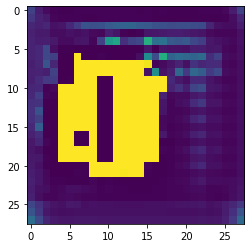

In [9]:
import matplotlib.pyplot as plt
plt.imshow(fake_images[0][0].cpu().detach().numpy())